In [20]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import pyproj

import sys
#Tools for evaraging model data
sys.path.append(r'../tools')

In [21]:
def correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y, timestep=3600.):
    """ Correct U, V vectors exported in neXtSIM 'Moorings.nc'
    
    Input
    -----
    n_u : 2D array with 'siu' from Moorings.nc
    n_v : 2D array with 'siv' from Moorings.nc
    lon0 : 2D array with 'lon' from barents_eps_*nc
    lat0 : 2D array with 'lat' from barents_eps_*nc
    b_x : 1D array with 'X' from barents_eps_*nc
    b_y : 1D array with 'Y' from barents_eps_*nc
    
    Returns
    -------
    b_u : 2D array with X component (U) of ice velocity in barents_eps_*nc coordinates
    b_v : 2D array with Y component (V) of ice velocity in barents_eps_*nc coordinates
    """
    nextsim_proj = pyproj.Proj('+proj=stere +a=6378273.0 +b=6356889.448910593 +lon_0=-45.0 +lat_0=90.0 +lat_ts=60.0 +type=crs')
    barents_proj = pyproj.Proj('+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06')

    bx0_n, by0_n = nextsim_proj(lon0, lat0)
    
    bx1_n = bx0_n + n_u * timestep
    by1_n = by0_n + n_v * timestep

    lon1, lat1 = nextsim_proj(bx1_n, by1_n, inverse=True)
    bx1, by1 = barents_proj(lon1, lat1)
    bx0, by0 = np.meshgrid(b_x, b_y)
    
    b_u = (bx1 - bx0) / timestep
    b_v = (by1 - by0) / timestep
    #b_u.mask = n_u.mask
    #b_v.mask = n_v.mask

    return b_u, b_v


In [3]:
'''
nov22_date = 19 #19th Nov 2022
m_idx = int((nov22_date - 1)*24) 

#m2name = '/data1/antonk/tmp/Moorings_barents.nc'
m2name = '/home/jovyan/data/NERSC_model_data/NERSC_modelMoorings_barents.nc'
with Dataset(m2name) as ds:
    n_u = ds['siu'][m_idx]
    n_v = ds['siv'][m_idx]
'''

##### Uploading data

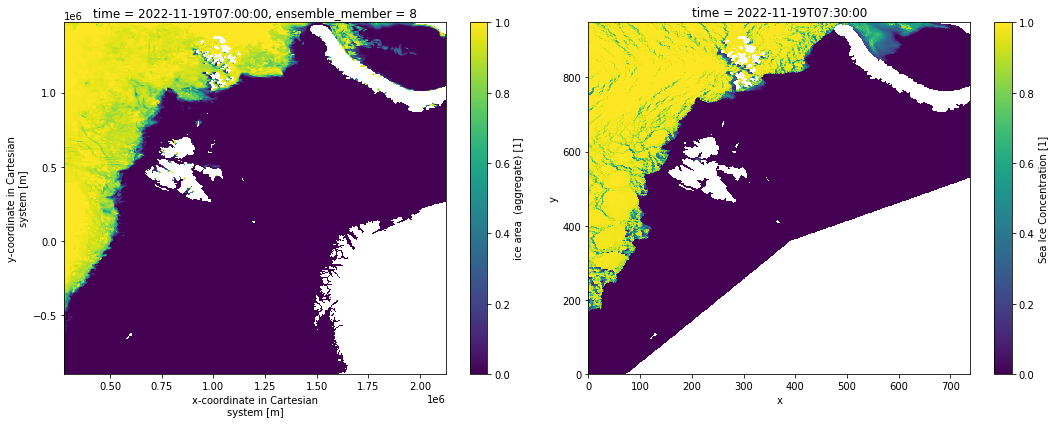

In [22]:
# Upload Barents2.5 and Neesc data for a quick look at teh concentration

data_barents = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20221119T06Z.nc")
data_nersc = xr.open_dataset('/home/jovyan/data/NERSC_model_data/NERSC_modelMoorings_barents.nc')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

data_barents.ice_concentration.sel(time='2022-11-19T07:00:00', ensemble_member=8).plot(ax=ax1)
data_nersc.sic.sel(time='2022-11-19T07').plot(ax=ax2)

plt.tight_layout()
plt.show()


##### Describing data

Data description (from https://catalogue.marine.copernicus.eu/documents/PUM/CMEMS-ARC-PUM-002-ALL.pdf)

ARCTIC_ANALYSISFORECAST_PHY_ICE_002_011 (neXtSIM)
A 1-day hindcast and 9-day forecast are produced every day using a single member. neXtSIM is forced with both atmospheric data and ocean data and nudged towards daily sea ice concentration observations.

neXtSIM is a stand-alone sea-ice model which can use winds and currents from a variety of atmospheric and oceanic models (hindcasts or forecasts). Its dynamical core is the Brittle-Bingham-Maxwell (BBM) rheology. The dynamical equations are solved with a finite element method on a Lagrangian (moving) triangular mesh. The code is a parallelised C++ code (used by Rampal et al., 2019, and presented by Samaké et al., 2017). The domain is a pan-Arctic one, with a mesh size of about 10 km (corresponding to about 7 km square grid resolution). 

(in my case they run it for 2.5 km as well)

There is also a thermodynamic component of the code and beneath the ice is a slab ocean with three variables: temperature, salinity and thickness. The temperature and salinity are modified by the heat and salinity fluxes determined by the thermodynamical model as ice melts and freezes and as the model interacts with the atmosphere. The thermodynamical model is a three-category model (detailed in Rampal et al., 2019, Appendix A): open water, newly-formed ice (treated as one ice layer and one snow layer; Semtner, 1976) and older ice (treated as two ice layers and a snow layer; Winton, 2000). Ocean forcing: To force neXtSIM, we use the ARCTIC_ANALYSIS_FORECAST_PHY_002_001_a (TOPAZ4) near-surface (30 m) ocean velocity and the mixed layer depth (MLD) directly in the model, while the temperature and salinity in the model’s slab ocean are relaxed towards the TOPAZ4 sea surface (3 m) temperature (SST) and salinity (SSS) (respectively) over a time scale of about a month. The thickness of the slab ocean is the MLD from TOPAZ4. Atmospheric forcing: We use ECMWF IFS forecast of the 10-m wind velocity, the 2-m air and dew point
temperatures (the latter is used to determine the specific humidity of air for the latent heat flux calculation), the mean sea level pressure, the long- and short-wave downwelling radiation, and the total precipitation (this becomes snow if the temperature is below 0◦C). Data Assimilation: The assimilation is performed before each forecast run using a data insertion method — an updated variable is calculated as a function of the forecast variable and observations. The simulation is then restarted using the updated variable and the model is run for 7 days to provide a forecast. Sea ice concentrations from the SI TAC
SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001 / OSI SAF product (a combination of SSMI/I and AMSR-2 products) are assimilated on a daily basis.

inbyte stereographic ;

stereographic:grid_mapping_name = "polar_stereographic" ;

stereographic:latitude_of_projection_origin = 90. ;

stereographic:longitude_of_projection_origin = -45. ;

stereographic:scale_factor_at_projection_origin = 1. ;

stereographic:straight_vertical_longitude_from_pole = -45. ;

stereographic: semi_major_axis = 6378273. ;

stereographic: semi_minor_axis = 6378273. ;

stereographic:proj4 = "+proj=stere +lat_0=90 +lat_ts=90 +lon_0=-45 +x_0=0 +y_0=0
+R=6378273 +ellps=sphere +units=m +no_defs" ;

stereographic:false_easting = 0. ;

stereographic:false_northing = 0. ; 


In [45]:
data_nersc

<xarray.Dataset>
Dimensions:    (time: 589, nv: 2, y: 949, x: 739)
Coordinates:
  * time       (time) datetime64[ns] 2022-11-01T00:29:59.999999488 ... 2022-1...
    longitude  (y, x) float32 ...
    latitude   (y, x) float32 ...
Dimensions without coordinates: nv, y, x
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    siu        (time, y, x) float32 ...
    siv        (time, y, x) float32 ...
    sic        (time, y, x) float32 ...
    sit        (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    institution:  NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    source:       neXtSIM model fields

In [50]:
for i, time in enumerate(time_period):
    print(f' time: {data_nersc.time.sel(time=time_period[i]).values}, end band {data_nersc.time_bnds[:,1].sel(time=time_period[i]).values}')


 time: 2022-11-19T07:30:00.000000000, end band 2022-11-19T08:00:00.000000000
 time: 2022-11-19T08:30:00.000000000, end band 2022-11-19T09:00:00.000000000
 time: 2022-11-19T09:29:59.999999488, end band 2022-11-19T10:00:00.000000000
 time: 2022-11-19T10:30:00.000000000, end band 2022-11-19T11:00:00.000000000
 time: 2022-11-19T11:30:00.000000000, end band 2022-11-19T12:00:00.000000000
 time: 2022-11-19T12:29:59.999999488, end band 2022-11-19T13:00:00.000000000
 time: 2022-11-19T13:30:00.000000000, end band 2022-11-19T14:00:00.000000000
 time: 2022-11-19T14:30:00.000000000, end band 2022-11-19T15:00:00.000000000
 time: 2022-11-19T15:29:59.999999488, end band 2022-11-19T16:00:00.000000000
 time: 2022-11-19T16:30:00.000000000, end band 2022-11-19T17:00:00.000000000
 time: 2022-11-19T17:30:00.000000000, end band 2022-11-19T18:00:00.000000000
 time: 2022-11-19T18:29:59.999999488, end band 2022-11-19T19:00:00.000000000
 time: 2022-11-19T19:30:00.000000000, end band 2022-11-19T20:00:00.000000000

##### Set time variables

The main difference from Barents2.5 data is that NEXTSIM model provides hourly mean data from the start. Each timestamp corresponds to an half an hour, for example mean value for 60 minutes between 7:00 and 8:00 is assigned for 7:30. Every third hour in timeline, though, is presented as more complex number, for example "2022-11-19T09:29:59.999999488".
To avoid such complex numbers I will use end band from the variable time_bnds (because the start of it is complex number as well)

In [23]:
# Calculate forecasting time period based on SAR1 and SAR2 timestamps

from model_data_prep import round_start_time, round_end_time, time_difference

# SAR images timestamps
t_sar1 = '2022-11-19T07:22:08'
t_sar2 = '2022-11-20T08:02:59'

# Rounding the SAR timestamps to align with the nearest whole hour of model timestamps
t_start = round_start_time(t_sar1)
t_end = round_end_time(t_sar2)

print(f'SAR1 time is {t_sar1}, Model start time for the time period is {t_start}')
print(f'SAR2 time is {t_sar2}, Model end time for the time period is {t_end}')


# Extracting the model time variavle data corresponding to the time period between the rounded start and end times
time_period = data_nersc.time.sel(time=slice(t_start,t_end))

print(f'The duration of the time period is {len(time_period)-1} whole hours')

SAR1 time is 2022-11-19T07:22:08, Model start time for the time period is 2022-11-19T07:00:00
SAR2 time is 2022-11-20T08:02:59, Model end time for the time period is 2022-11-20T09:00:00
The duration of the time period is 25 whole hours


In [24]:
time_period

<xarray.DataArray 'time' (time: 26)>
array(['2022-11-19T07:30:00.000000000', '2022-11-19T08:30:00.000000000',
       '2022-11-19T09:29:59.999999488', '2022-11-19T10:30:00.000000000',
       '2022-11-19T11:30:00.000000000', '2022-11-19T12:29:59.999999488',
       '2022-11-19T13:30:00.000000000', '2022-11-19T14:30:00.000000000',
       '2022-11-19T15:29:59.999999488', '2022-11-19T16:30:00.000000000',
       '2022-11-19T17:30:00.000000000', '2022-11-19T18:29:59.999999488',
       '2022-11-19T19:30:00.000000000', '2022-11-19T20:30:00.000000000',
       '2022-11-19T21:29:59.999999488', '2022-11-19T22:30:00.000000000',
       '2022-11-19T23:30:00.000000000', '2022-11-20T00:29:59.999999488',
       '2022-11-20T01:30:00.000000000', '2022-11-20T02:30:00.000000000',
       '2022-11-20T03:29:59.999999488', '2022-11-20T04:30:00.000000000',
       '2022-11-20T05:30:00.000000000', '2022-11-20T06:29:59.999999488',
       '2022-11-20T07:30:00.000000000', '2022-11-20T08:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-11-19T07:30:00 ... 2022-11-20T08:30:00
Attributes:
    standard_name:  time
    long_name:      simulation time
    bounds:         time_bnds

In [25]:
#Export time differences calculated in barents_model_drift_export.ipynb
%store -r time_diff_start
%store -r time_diff_end
%store -r total_time_diff

print(f'Time difference between SAR1 and the start of the model time period is {time_diff_start} seconds ({np.around(time_diff_start/60, 3)} minutes).') 
print(f'Time difference between SAR2 and the end of the model time period is {time_diff_end} seconds ({np.around(time_diff_end/60, 3)} minutes).')
print(f'Total time difference between SAR1 and SAR2 images is {total_time_diff} seconds  ({np.around(total_time_diff/86400, 3)} days).') 

Time difference between SAR1 and the start of the model time period is 1328 seconds (22.133 minutes).
Time difference between SAR2 and the end of the model time period is 3421 seconds (57.017 minutes).
Total time difference between SAR1 and SAR2 images is 88851 seconds  (1.028 days).


##### Extractin/importing variables

1) First we need to extract sea ice velocities from Nextsim model. They are on the sae grid as Barents2.5 but valocities values are nore projected along the Barents2.5 grid and need correction

In [26]:
# Extract sea ice related variables
n_u = data_nersc['siu'] # ice velocity (x) 
n_v = data_nersc['siv'] # ice velocity (y)
siconc = data_nersc['sic'] # ice area  (aggregate)

2) Then import subset extent bounds from the notebook with drift calculation for SAR1 - SAR2 (SAR1-SAR2_drift.ipynb
It takes bounds from the sar image nansat object and the correspond directly to the tiff bound without buffer zone.
Drift data exported within this bounds would have the same grid, projection as algorithm data that make it easy to compare

In [348]:
#Import variables for extracting subsets from SAR1-SAR2_drift.ipynb
%store -r r
%store -r c
%store -r X_subset
%store -r Y_subset
%store -r lon_subset
%store -r lat_subset

3) Then we need to extract all variables within the subset extent

In [340]:
# Extract other varibles within the bound
#pick ensmble
#n_u_subset = n_u.sel(time=slice(t_start,t_end))#[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
#n_v_subset = n_v.sel(time=slice(t_start,t_end))#[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
ice_u_subset = n_u.sel(time=slice(t_start,t_end))[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
ice_v_subset = n_v.sel(time=slice(t_start,t_end))[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
siconc_subset  = siconc.sel(time=slice(t_start,t_end))[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)


4) Then we need to correct Nextsim vectors according to Barents2.5 grid so vectors would show values of drift along Barents2.5 grid.

In [351]:
#for teh whole grid
X = data_barents['X'][:]
Y = data_barents['Y'][:]    
lon = data_barents['lon'][:]
lat = data_barents['lat'][:]

In [355]:
# For subset

X = X_subset
Y = Y_subset    
lon = lon_subset
lat = lat_subset

In [350]:
b_u_list = []
b_v_list = []

for i in range(len(ice_u_subset)):
    temp_b_u, temp_b_v = correct_vectors(ice_u_subset[i], ice_v_subset[i], lon, lat, X, Y)
    b_u_list.append(temp_b_u)
    b_v_list.append(temp_b_v)


In [96]:
Y_subset.shape

(154,)

In [51]:
b_u_list = []
b_v_list = []

for i in range(len(ice_u_subset)):
    temp_b_u, temp_b_v = correct_vectors(ice_u_subset[i], ice_v_subset[i], lon_subset, lat_subset, X_subset, Y_subset)
    b_u_list.append(temp_b_u)
    b_v_list.append(temp_b_v)


In [352]:
ice_u_corrected = xr.DataArray(b_u_list, dims=('time', 'y', 'x'), coords={'time': ice_u_subset.time, 'y': ice_u_subset.y, 'x': ice_u_subset.x})
ice_v_corrected = xr.DataArray(b_v_list, dims=('time', 'y', 'x'), coords={'time': ice_v_subset.time, 'y': ice_v_subset.y, 'x': ice_v_subset.x})

In [353]:
%store ice_u_corrected
%store ice_v_corrected

Stored 'ice_u_corrected' (DataArray)
Stored 'ice_v_corrected' (DataArray)


In [13]:
from model_data_prep import cumulative_ice_disp_nextsim

In [339]:
#For barents model
ice_u_b = data_barents.ice_u.sel(time=slice(t_start,t_end), ensemble_member = 8)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
ice_v_b = data_barents.ice_v.sel(time=slice(t_start,t_end), ensemble_member = 8)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)

In [333]:
%store -r time_period_barents
# Store the selected coordinate arrays in lists to collect arrays from different iterationsfor further processing
# Create coordinate arrays  
x_sub, y_sub = np.meshgrid(X, Y)
# Turn arrays into vectors
x_sub = x_sub.flatten()
y_sub = y_sub.flatten()

# Store the selected coordinate arrays in lists to collect arrays from different iterationsfor further processing
xx = [x_sub]
yy = [y_sub]

#Prepare lsit for integrated drift for comparison with model
int_dx_b = []
int_dy_b = []


for t in range(1, len(time_period_barents)):
    #print(f'{t} hour done')
    u1 = ice_u_b.sel(time=time_period_barents[t-1])
    u2 = ice_u_b.sel(time=time_period_barents[t])

    v1 = ice_v_b.sel(time=time_period_barents[t-1])
    v2 = ice_v_b.sel(time=time_period_barents[t])

    
    if t == 1:
        u_displacement = (u2+u1)*(3600-time_diff_start)/2
        v_displacement = (v2+v1)*(3600-time_diff_start)/2
        #print("start", t, u_displacement.values)
    elif t in range(2, len(time_period)-1):
        u_displacement = (u2+u1)*3600/2
        v_displacement = (v2+v1)*3600/2
        #print(t, u_displacement.values)
    elif t == len(time_period)-1:
        u_displacement = (u2+u1)*(3600-time_diff_end)/2
        v_displacement = (v2+v1)*(3600-time_diff_end)/2
            #print("end", t, u_displacement.values)
    #print(f'{time_period[t].values} barents: {u_displacement[460][36].values nextsim {v_displacement[460][36].values}')
    #print(np.sqrt(u_displacement[460][36].values**2+v_displacement[460][36].values**2))
    

    # Create interpolator object with grid coordinates and corresponded drift values
    ut_interpolator = RegularGridInterpolator((Y.data,X.data), u_displacement.data, bounds_error=False, fill_value = None)
    dx = ut_interpolator((y_sub, x_sub))
    #print("dx", dx)
    vt_interpolator = RegularGridInterpolator((Y.data,X.data), v_displacement.data, bounds_error=False, fill_value = None)
    dy = vt_interpolator((y_sub, x_sub)) 
    #print("dy", dy)
    # Calculate new coordinates based on displacement 
    x_sub = x_sub + dx
    y_sub = y_sub + dy
    # Append them to the list
    xx.append(x_sub)
    yy.append(y_sub)


    #Calculate total integrated drift
    if t == 1:
        dx_total = dx
        dy_total = dy
        int_dx_b.append(dx_total)
        int_dy_b.append(dy_total)
    else:
        dx_total = int_dx_b[-1] + dx
        dy_total = int_dy_b[-1] + dy
        int_dx_b.append(dx_total)
        int_dy_b.append(dy_total)
     
    #print(f'1) {np.sqrt(int_dx_b[t-1][339976]**2+int_dy_b[t-1][339976]**2)}')
    print(f'after {np.sqrt(int_dx_b[t-1][339976]**2+int_dy_b[t-1][339976]**2)}')
    #print(f'2) {u_displacement.values.flatten()[339976]}, after {int_dx[t][339976]}, {dx[339976]} ')


after 278.050945570669
after 720.7639137990902
after 1160.1244983859235
after 1592.0970400958604
after 2014.7739345963696
after 2429.2070140025303
after 2838.4576839511383
after 3245.7175203511083
after 3653.0372043127168
after 4061.2474376985383
after 4471.104773068394
after 4883.811691105685
after 5298.795160704273
after 5712.910701293243
after 6122.108462720641
after 6523.0263156870615
after 6915.030060355933
after 7300.154811627177
after 7681.242785020853
after 8059.809865003581
after 8435.924443792814
after 8808.43409165213
after 9175.410552386773
after 9535.338504681387
after 9552.817039081554
after 9570.295083608831


In [338]:
%store int_dx_b
%store int_dy_b
%store xx
%store yy

Stored 'int_dx_b' (list)
Stored 'int_dy_b' (list)
Stored 'xx' (list)
Stored 'yy' (list)


In [357]:
#For nersc model
# Create coordinate arrays  
x_sub, y_sub = np.meshgrid(X, Y)
# Turn arrays into vectors
x_sub = x_sub.flatten()
y_sub = y_sub.flatten()

# Store the selected coordinate arrays in lists to collect arrays from different iterationsfor further processing
xx = [x_sub]
yy = [y_sub]

#Prepare lsit for integrated drift for comparison with model
int_dx = []
int_dy = []



for t in range(len(time_period)):
    u = ice_u_corrected.sel(time=time_period[t])
    v = ice_v_corrected.sel(time=time_period[t])
    if t == 0:
        u_displacement = (u)*(3600-time_diff_start)
        v_displacement = (v)*(3600-time_diff_start)
        #print("start", t, u_displacement.values)
    elif t in range(1, len(time_period)-1):
        u_displacement = (u)*3600
        v_displacement = (v)*3600
        #print(t, u_displacement.values)
    elif t == len(time_period)-1:
        u_displacement = (u)*(3600-time_diff_end)
        v_displacement = (v)*(3600-time_diff_end)
            #print("end", t, u_displacement.values)
    #print(f'{time_period[t].values} barents: {u_displacement[460][36].values} nextsim {v_displacement[460][36].values}')
    
    # Create interpolator object with grid coordinates and corresponded drift values
    ut_interpolator = RegularGridInterpolator((Y.data,X.data), u_displacement.data, bounds_error=False, fill_value = None)
    dx = ut_interpolator((y_sub, x_sub))
    #print("dx", dx)
    vt_interpolator = RegularGridInterpolator((Y.data,X.data), v_displacement.data, bounds_error=False, fill_value = None)
    dy = vt_interpolator((y_sub, x_sub)) 
    #print("dy", dy)
    # Calculate new coordinates based on displacement 
    x_sub = x_sub + dx
    y_sub = y_sub + dy
    # Append them to the list
    xx.append(x_sub)
    yy.append(y_sub)


    #Calculate total integrated drift
    if t == 0:
        dx_total = dx
        dy_total = dy
        int_dx.append(dx_total)
        int_dy.append(dy_total)
    else:
        dx_total = int_dx[-1] + dx
        dy_total = int_dy[-1] + dy
        int_dx.append(dx_total)
        int_dy.append(dy_total)
    
    #print(f'1){t}, {np.sqrt(u_displacement[460][36].values**2+v_displacement[460][36].values**2)}, after {np.sqrt(int_dx[t][339976]**2+int_dy[t][339976]**2)}')
    #print(f'2) {u_displacement.values.flatten()[339976]}, after {int_dx[t][339976]}, {dx[339976]} ')


In [358]:
%store int_dx
%store int_dy
%store xx
%store yy

Stored 'int_dx' (list)
Stored 'int_dy' (list)
Stored 'xx' (list)
Stored 'yy' (list)


In [76]:
xx, yy, int_dx, int_dy = cumulative_ice_disp_nextsim(X_subset,Y_subset, ice_u_corrected, ice_v_corrected, time_period, time_diff_start,time_diff_end)


0 hour done
1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done


In [269]:
lon1.shape

(701311,)

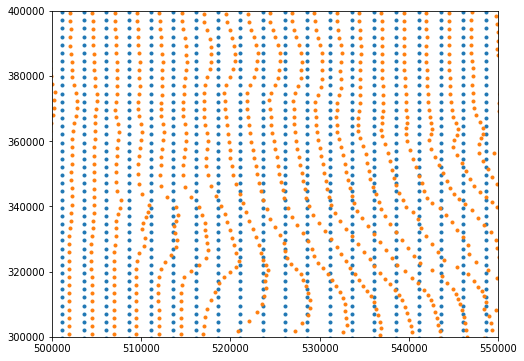

In [261]:
space_step=1

plt.figure(figsize=(8, 6))

plt.plot(xx[0][::space_step], yy[0][::space_step], '.')
#plt.plot(xx[10][::space_step], yy[10][::space_step], '.')
plt.plot(xx[25][::space_step], yy[25][::space_step], '.')
plt.xlim([5e5, 5.5e5])
plt.ylim([3e5, 4e5])

plt.show()

In [78]:
output_dir_subset_comp =  r'/home/jovyan/data/model_data_process_output/for_comparison_lambert'

In [268]:
lon1 = lon.data.flatten()#lon_subset.data.flatten()
lat1 = lat.data.flatten()#lat_subset.data.flatten()

In [270]:
import pandas as pd
import os
import csv
points=zip(lon1, lat1, int_dx[-1], int_dy[-1])
header=['lon1','lat1', 'du','dv']

time_index_start = pd.to_datetime(time_period[0].values)
time_index_end = pd.to_datetime(time_period[-1].values)
filename_t_start = time_index_start.strftime('%Y%m%dT%H')
filename_t_end = time_index_end.strftime('%Y%m%dT%H')
        
file_name = f'total_nextsim_displacement_{filename_t_start}-{filename_t_end}_all_data.csv'
file_path = os.path.join(output_dir_subset_comp, file_name)

with open(file_path, 'w', newline='') as csv_file:
            out = csv.writer(csv_file, delimiter=',')
            out.writerow(header)
            out.writerows(points)

In [52]:
for t in range(0,len(time_period)):
    print(t, t == t in range(1, len(time_period)-1), t == len(time_period)-1, t == 0)

0 False False True
1 True False False
2 True False False
3 True False False
4 True False False
5 True False False
6 True False False
7 True False False
8 True False False
9 True False False
10 True False False
11 True False False
12 True False False
13 True False False
14 True False False
15 True False False
16 True False False
17 True False False
18 True False False
19 True False False
20 True False False
21 True False False
22 True False False
23 True False False
24 True False False
25 False True False


In [75]:
from scipy.interpolate import RegularGridInterpolator

def cumulative_ice_disp_nextsim(X, Y, ice_u, ice_v, time_period, time_diff_start, time_diff_end):
    """
    Computes the integrated displacement along the x and y axes for each hour (or its fraction) of the forecasting  time period for nextsim model.
    The calculation for each hour is cumulative. For instance, the displacement value at the 1st hour represents the displacement 
    for that hour alone, while the value at the 5th hour represents the cumulative displacement over the first five hours.
    Such displacmeents are intended for drift-driven warping
    
    This function also derives the hourly coordinates (xx and yy) in the Lagrangian reference frame, where the model coordinates 
    X and Y serve as the starting grid coordinates.

    Parameters:
    - X, Y (DataArray): Cartesian coordinates from the model or its subset.
    - ice_u, ice_v (DataArray): Ice velocities along the x and y axes, respectively.
    - time_period (DataArray): The input xarray model time period.
    - time_diff_start (int): Time difference in seconds between SAR1 and the start of the model time period.
    - time_diff_end (int): Time difference in seconds between SAR2 and the end of the model time period.

    Returns: 
    - xx, yy (list): Lists of coordinates corresponding to each timestamp in the time period. The lengths of xx and yy are equivalent to len(time_period).
    - int_dx, int_dy (list): Lists of total cumulative displacements for each hour of the time period. The lengths of int_dx and int_dy are len(time_period) - 1.
    """


    # Create coordinate arrays  
    x_sub, y_sub = np.meshgrid(X, Y)
    # Turn arrays into vectors
    x_sub = x_sub.flatten()
    y_sub = y_sub.flatten()

    # Store the selected coordinate arrays in lists to collect arrays from different iterationsfor further processing
    xx = [x_sub]
    yy = [y_sub]

    #Prepare lsit for integrated drift for comparison with model
    int_dx = []
    int_dy = []

    for t in range(len(time_period)):
        print(f'{t} hour done')
        u = ice_u.sel(time=time_period[t])#
        v = ice_v.sel(time=time_period[t])
   
        # Calculate displacement along lon (u) and lat (v) based on mean velovity
        # The first and the last displacemnets are calculated differently based on time difference with the SAR acquisitions
        if t == 0:
            u_displacement = (u)*(3600-time_diff_start)
            v_displacement = (v)*(3600-time_diff_start)
            #print("start", t, u_displacement.values)
        elif t in range(1, len(time_period)-1):
            u_displacement = (u)*3600
            v_displacement = (v)*3600
            #print(t, u_displacement.values)
        elif t == len(time_period)-1:
            u_displacement = (u)*(3600-time_diff_end)
            v_displacement = (v)*(3600-time_diff_end)
            #print("end", t, u_displacement.values)

        # Create interpolator object with grid coordinates and corresponded drift values
        ut_interpolator = RegularGridInterpolator((Y.data,X.data), u_displacement.data, bounds_error=False, fill_value = None)
        dx = ut_interpolator((y_sub, x_sub))
        #print("dx", dx)
        vt_interpolator = RegularGridInterpolator((Y.data,X.data), v_displacement.data, bounds_error=False, fill_value = None)
        dy = vt_interpolator((y_sub, x_sub)) 
        #print("dy", dy)
        # Calculate new coordinates based on displacement 
        x_sub = x_sub + dx
        y_sub = y_sub + dy
        # Append them to the list
        xx.append(x_sub)
        yy.append(y_sub)


        #Calculate total integrated drift
        if t == 0:
            dx_total = dx
            dy_total = dy
            int_dx.append(dx_total)
            int_dy.append(dy_total)
        else:
            dx_total = int_dx[-1] + dx
            dy_total = int_dy[-1] + dy
            int_dx.append(dx_total)
            int_dy.append(dy_total)
            
    return xx, yy, int_dx, int_dy


#### Calculated inegrated drift

In [ ]:
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].quiver(b_x[::step], b_y[::step], b_u[::step, ::step], b_v[::step, ::step], np.hypot(b_u[::step, ::step], b_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')

axs[1].quiver(b_x[::step], b_y[::step], ice_u[::step, ::step], ice_v[::step, ::step], np.hypot(ice_u[::step, ::step], ice_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

plt.show()

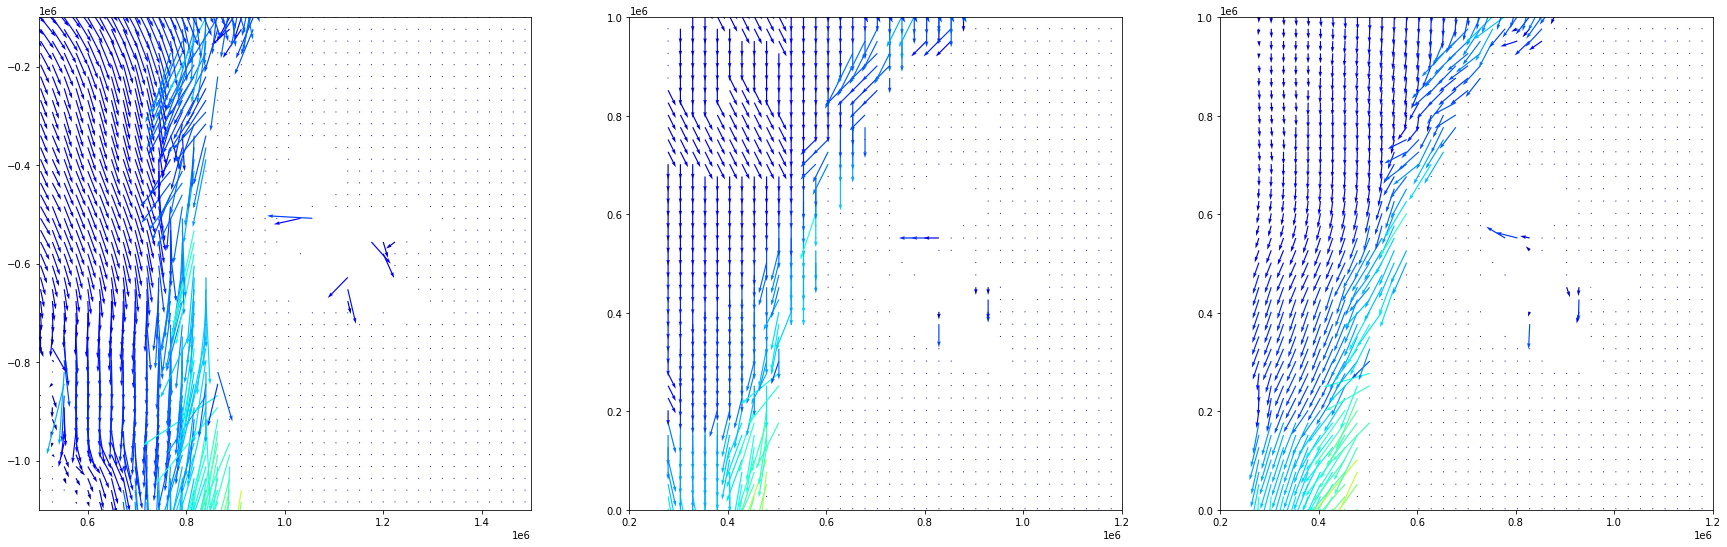

In [7]:
# JUST FOR COMPARISON WITH ANOTHER GRID

with Dataset('/data1/antonk/tmp/Moorings_barents.nc') as ds:
    n_u = ds['siu'][23]
    n_v = ds['siv'][23]

with Dataset('/data1/antonk/tmp/Moorings_2022d305.nc') as ds:
    t_u = ds['siu'][47]
    t_v = ds['siv'][47]

with Dataset('/Data/sim/data/nextsim_output_grids/topaz6_grid.nc') as ds:
    t_x = ds['x'][:] * 100000
    t_y = ds['y'][:] * 100000

b_u, b_v = correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y)    
    
fig, axs = plt.subplots(1,3,figsize=(30,10))
step = 8
#axs[0].pcolormesh(m1x[::step], m1y[::step], , cmap='jet', vmin=0, vmax=0.1)
axs[0].quiver(t_x[::step], t_y[::step], t_u[::step, ::step], t_v[::step, ::step], np.hypot(t_u[::step, ::step], t_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000001, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.5e6,1.5e6])
axs[0].set_ylim([-1.1e6,-0.1e6])
axs[0].set_aspect('equal')

step = 10
#axs[1].pcolormesh(m2x[::step], m2y[::step],  cmap='jet', vmin=0, vmax=0.1)
axs[1].quiver(b_x[::step], b_y[::step], n_u[::step, ::step], n_v[::step, ::step], np.hypot(n_u[::step, ::step], n_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000002, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.2e6,1.2e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

#axs[2].pcolormesh(m2x[::step], m2y[::step], cmap='jet', vmin=0, vmax=0.1)
axs[2].quiver(b_x[::step], b_y[::step], b_u[::step, ::step], b_v[::step, ::step], np.hypot(b_u[::step, ::step], b_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000002, cmap='jet', clim=[0, 0.5])
axs[2].set_xlim([0.2e6,1.2e6])
axs[2].set_ylim([0,1e6])
axs[2].set_aspect('equal')

plt.show()